# Start with importing required Python packages

In [2]:
# our own package:
import symbionic

# useful data science packages:
import numpy as np
import matplotlib.pyplot as plt

# machine learning packages:
from sklearn.utils import class_weight

# for loading the data from the web
import requests

# Loading the EMG data

In [3]:
# Download the files from github to your local drive
path = 'https://github.com/matthijscox/symbionic/raw/master/data/'
files = ['raw1.bin', 'raw2.bin', 'raw3.bin', 'raw4.bin', 'raw5.bin' , 'raw6.bin']
folder = ''

for f in files:
    req = requests.get(path + f)
    open(f, 'wb').write(req.content)

In [14]:
# Alternative to the above: uncomment and manually place data in a folder and read it in
'''
folder = r'C:\yourfolder'
folder = folder.replace('\\','/')
if not folder.endswith('/'):
    folder = folder + '/'
'''

In [4]:
# load the data for each individual gesture
emg_data = symbionic.EmgData()
emg_data.load(folder + 'raw1.bin', gesture='g1')
emg_data.load(folder + 'raw2.bin', gesture='g2')
emg_data.load(folder + 'raw3.bin', gesture='g3')
emg_data.load(folder + 'raw4.bin', gesture='g4')
emg_data.load(folder + 'raw5.bin', gesture='g5')
emg_data.load(folder + 'raw6.bin', gesture='g6')

# also labeling the data (in other words, finding which gestures are occuring where in the data)
emg_data.label_patterns()

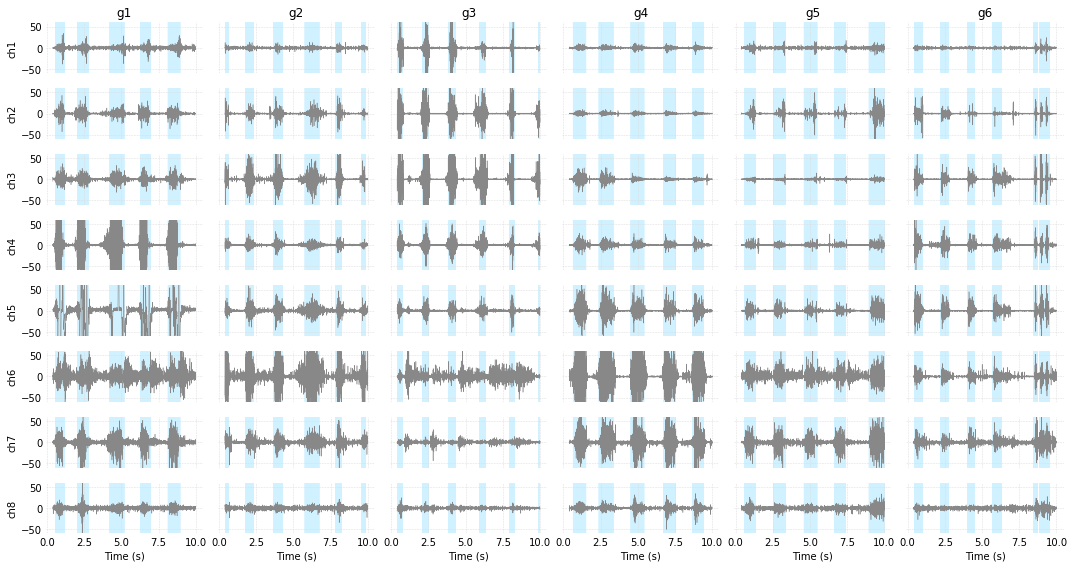

In [5]:
# plotting the raw data:
p = emg_data.plot(time=(0.4,10))

# here's a customized version:
# p = emg_data.plot(time=(0.4,1.5), show_envelope=True, figsize=(4,8), ylim=(-80,80))

# example on how to save the data to a png:
# p.savefig('C:/Users/username/Desktop/labeled_gesture1.png',dpi=100)

# Converting the loaded data for the learning algorithm
Get windowed training samples 

The output is a dictionary with three fields:
 - X is the training data, with 3 dimensions and shape = [windowed samples, time samples, EMG channels] Where windowed samples is the signal cut with a window size, time samples is the time within the window and the EMG channels represent which channel the window was taken from.
 - y is the class label at the end of the window, integer (0 = noise, 1 = first gesture, ...)
 - dt is the time (at the end of the window) since the last classified gesture (for analysis only, DO NOT USE IN MODELS!)

In [7]:
# Note: the input window size is in seconds
result = emg_data.get_training_samples(window=0.3)

# check out the shape of the training data
result['X'].shape

(5888, 195, 8)

In [8]:
from keras.utils import np_utils

# getting the data out of the dictionary
data = result['X']
labels = result['y']
dt = result['dt']

# select less data (only those samples close to an actual gesture)
selected_indices = np.where((dt>-0.2) & (dt<0.90))
data = data[selected_indices]
labels = labels[selected_indices]
dt = dt[selected_indices]

# convert integers to dummy variables (i.e. 'one hot encoded' -> google term if unknown)
dummy_y = np_utils.to_categorical(labels)

# create class weights
#class_weights = class_weight.compute_class_weight('balanced', np.unique(labels), labels)
class_weights = np.ones(len(np.unique(labels)))
class_weights[0] = 0.1 # less weight on the 'noise' label

c:\Localdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


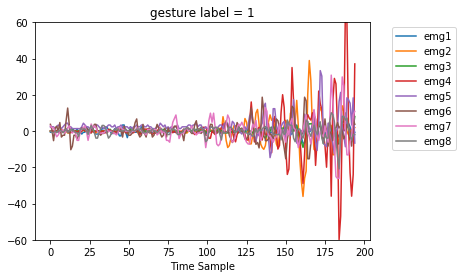

In [9]:
# plotting a single windowed sample
index = 301

plt.figure()
plt.plot(data[index])
plt.ylim((-60,60))
plt.title("gesture label = {0}".format(labels[index]))
plt.xlabel('Time Sample')
plt.legend(emg_data.channel_names, loc=2, bbox_to_anchor=(1.05,1))
plt.show()

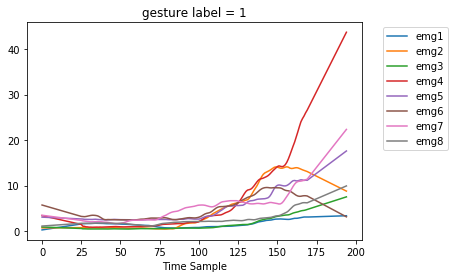

In [10]:
# plotting the smoothed envelope function of a single windowed sample
# this makes the gestures much easier to see, but you may lose some frequency information

def calc_envelope(signal):
    envelope = symbionic.calc_envelope(signal,smooth=51)
    return envelope

envelope_for_indexed_sample = np.apply_along_axis(calc_envelope,0,data[index])

plt.plot(envelope_for_indexed_sample)
plt.title("gesture label = {0}".format(labels[index]))
plt.xlabel('Time Sample')
plt.legend(emg_data.channel_names, loc=2, bbox_to_anchor=(1.05,1))
plt.show()

In [11]:
# creating envelope functions for all samples (takes a while)
envelopes = np.apply_along_axis(lambda x: symbionic.calc_envelope(x,smooth=51),1,data)
envelopes = np.swapaxes(envelopes,1,2)
flattened_data = data.reshape((data.shape[0],data.shape[1]*data.shape[2]))
flattened_envelopes = envelopes.reshape((data.shape[0],data.shape[1]*data.shape[2]))

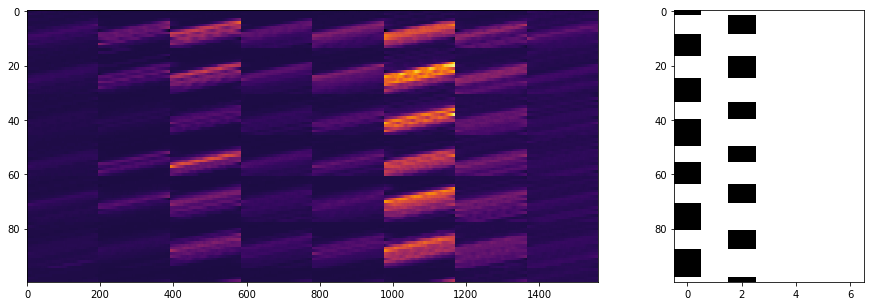

In [10]:
# This is a harder figure to understand... (don't spend to much time to understand this one, can be ingored)
# On the left: heatmap of the envelopes, with the 8 channels side by side, on y window samples, on x time samples. Read from top to bottom
# On the right: which label is being used per sample, only label 0 and 2 are shown in this case
f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,5))
a0.imshow(flattened_envelopes[500:600,:], cmap = 'inferno', interpolation='nearest', aspect='auto')
a1.imshow(dummy_y[500:600,:], cmap = 'binary', interpolation='nearest', aspect='auto')
plt.show()

In [13]:
# a simple feature to use the absolute maximum value of the last part of the window

def absmax_at_end(signal):
    return np.max(abs(signal[-50:]))
    
maxabs = np.apply_along_axis(absmax_at_end,1,data) 

# Machine Learning
## Neural Network

In [14]:
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers, regularizers

# Using the flattened envelope data for simplicity
# Ideally ofcourse we build a model on the 3D raw data
X = flattened_envelopes
try:
    input_dim = X.shape[1]
except IndexError:
    input_dim = 1

model = Sequential()

# adding layers to the model
# I was playing with the number of layers and settings, but cannot improve much so far yet
model.add(Dense(units=64, activation='relu', input_dim=input_dim))
#                kernel_regularizer=regularizers.l2(0.005),
#                activity_regularizer=regularizers.l1(0.005)))
#model.add(Dense(units=100, activation='relu'))
#                kernel_regularizer=regularizers.l2(0.005),
#                activity_regularizer=regularizers.l1(0.005)))
model.add(Dense(units=dummy_y.shape[1], activation='softmax', input_dim=input_dim))

# configure the model using compile
# also playing around a bit here, but not that useful so far
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#adam = optimizers.Adam( beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#adam = optimizers.Adam()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['categorical_accuracy'])

# logistical regression example, can be used as a bench mark as well:
# model.add(Dense(dummy_y.shape[1], activation='sigmoid', input_dim=input_dim))
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

Wsave = model.get_weights()

In [15]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test_NN, dt_train, dt_test_NN = train_test_split(X, dummy_y, dt, test_size=0.2)

In [16]:
# train the model
model.set_weights(Wsave) # if you do not want it to remember your runs
history = model.fit(X_train, y_train, validation_data=(X_test,y_test_NN), epochs=100,batch_size=32,class_weight=class_weights,verbose=True)
NN_pred_labels = np.argmax(model.predict(X_test),axis=1)

Train on 2288 samples, validate on 573 samples
Epoch 1/100
2288/2288 [==============================] - 2s 826us/step - loss: 3.5083 - categorical_accuracy: 0.5826 - val_loss: 1.8202 - val_categorical_accuracy: 0.7347
Epoch 2/100
2288/2288 [==============================] - 1s 292us/step - loss: 1.3068 - categorical_accuracy: 0.7570 - val_loss: 1.0035 - val_categorical_accuracy: 0.7836
Epoch 3/100
2288/2288 [==============================] - 1s 273us/step - loss: 0.7936 - categorical_accuracy: 0.8182 - val_loss: 0.7020 - val_categorical_accuracy: 0.8272
Epoch 4/100
2288/2288 [==============================] - 1s 268us/step - loss: 0.6677 - categorical_accuracy: 0.8357 - val_loss: 0.6407 - val_categorical_accuracy: 0.8325
Epoch 5/100
2288/2288 [==============================] - 1s 222us/step - loss: 0.5958 - categorical_accuracy: 0.8514 - val_loss: 0.5538 - val_categorical_accuracy: 0.8586
Epoch 6/100
2288/2288 [==============================] - 1s 248us/step - loss: 0.5835 - categorica

2288/2288 [==============================] - 0s 150us/step - loss: 0.2324 - categorical_accuracy: 0.9349 - val_loss: 0.4069 - val_categorical_accuracy: 0.8918
Epoch 49/100
2288/2288 [==============================] - 1s 222us/step - loss: 0.2778 - categorical_accuracy: 0.9244 - val_loss: 0.4380 - val_categorical_accuracy: 0.8761
Epoch 50/100
2288/2288 [==============================] - 0s 135us/step - loss: 0.2783 - categorical_accuracy: 0.9191 - val_loss: 0.5398 - val_categorical_accuracy: 0.8709
Epoch 51/100
2288/2288 [==============================] - 1s 239us/step - loss: 0.2408 - categorical_accuracy: 0.9358 - val_loss: 0.4259 - val_categorical_accuracy: 0.8918
Epoch 52/100
2288/2288 [==============================] - 0s 132us/step - loss: 0.2300 - categorical_accuracy: 0.9318 - val_loss: 0.4885 - val_categorical_accuracy: 0.8726
Epoch 53/100
2288/2288 [==============================] - 1s 221us/step - loss: 0.2380 - categorical_accuracy: 0.9340 - val_loss: 0.4143 - val_categorica

Epoch 96/100
2288/2288 [==============================] - 0s 137us/step - loss: 0.2091 - categorical_accuracy: 0.9436 - val_loss: 0.5747 - val_categorical_accuracy: 0.8674
Epoch 97/100
2288/2288 [==============================] - 0s 134us/step - loss: 0.2141 - categorical_accuracy: 0.9432 - val_loss: 0.5348 - val_categorical_accuracy: 0.8656
Epoch 98/100
2288/2288 [==============================] - 0s 135us/step - loss: 0.1966 - categorical_accuracy: 0.9541 - val_loss: 0.5592 - val_categorical_accuracy: 0.8813
Epoch 99/100
2288/2288 [==============================] - 0s 138us/step - loss: 0.1618 - categorical_accuracy: 0.9650 - val_loss: 0.4167 - val_categorical_accuracy: 0.8970
Epoch 100/100
2288/2288 [==============================] - 0s 151us/step - loss: 0.1620 - categorical_accuracy: 0.9615 - val_loss: 0.3822 - val_categorical_accuracy: 0.9040


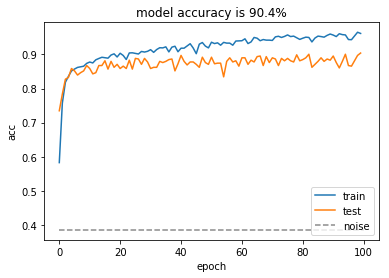

In [17]:
# Plotting the accuracy as the fit progresses

noise_acc = sum(labels==0)/len(labels) # noise level benchmark (if we classify all data as noise or 'no gesture')

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.plot([0,len(history.history['categorical_accuracy'])],[noise_acc,noise_acc],linestyle='--',color='#8B8B8B')
plt.title('model accuracy is {:.1f}%'.format(100*history.history['val_categorical_accuracy'][-1]))
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test','noise'], loc='lower right')
plt.show()

## Random Forest
A very simple model to benchmark against: training a random forest on the absmax feature.

In [18]:
# random forest instead...
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# split the data
X = maxabs
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test_RF, dt_train, dt_test_RF = train_test_split(X, dummy_y, dt, test_size=0.2)

forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)
forest_predictions = forest_model.predict(X_test)
forest_pred_labels = np.argmax(forest_predictions,axis=1)
noise_acc = sum(labels==0)/len(labels)*100
forest_acc = accuracy_score(y_test_RF,forest_predictions)*100

print("Noise level is {:.1f}%".format(noise_acc))
print("Fit accuracy is {:.1f}%".format(forest_acc))

Noise level is 38.5%
Fit accuracy is 74.5%


# Evaluating the results
## Confusion matrix
This shows how often a gesture is classified by the model as another gesture, very insightful to see where things go wrong.

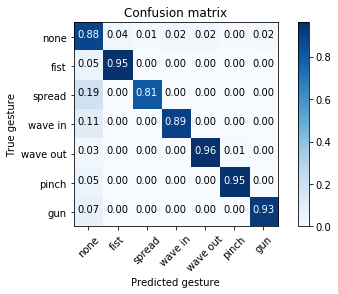

In [19]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
y_test_labels_NN = np.argmax(y_test_NN,axis=1)
NN_cnf_matrix = confusion_matrix(y_test_labels_NN, NN_pred_labels)
y_test_labels_RF = np.argmax(y_test_RF,axis=1)
RF_cnf_matrix = confusion_matrix(y_test_labels_RF, forest_pred_labels)
np.set_printoptions(precision=2)


# Plot normalized confusion matrix
plt.figure()
symbionic.plot_confusion_matrix(NN_cnf_matrix, classes=['none','fist','spread','wave in','wave out','pinch','gun'], normalize=True)
plt.show()



## Temporal classification accuracy
This shows how often gestures are classified wrong or right with respect to the start of a gesture.


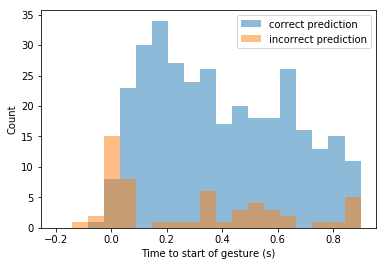

In [20]:
dt_test = dt_test_NN
y_test_labels = y_test_labels_NN
pred_labels = NN_pred_labels

bins = np.linspace(min(dt_test),max(dt_test),20)
correct_count = np.histogram(dt_test[(y_test_labels==pred_labels)],bins=bins)
total_count = np.histogram(dt_test,bins=bins)
acc = correct_count[0]/total_count[0]
acc[np.isnan(acc)]=1
dt_acc = correct_count[1]

# Note: excluding the noise labels, as we're not interested so much in predicting those correctly
plt.hist(dt_test[(y_test_labels==pred_labels) & (y_test_labels!=0)], bins=bins, alpha=0.5, label='correct prediction')
plt.hist(dt_test[y_test_labels!=pred_labels], bins=bins, alpha=0.5, label='incorrect prediction')
plt.legend(loc='upper right')
#plt.plot(bins[:-1],acc*100)
plt.xlabel('Time to start of gesture (s)')
plt.ylabel('Count')
plt.show()